# **Задание.**

В статье [О том, что происходит, когда в поиске Google используют слово «vs»](https://habr.com/ru/company/ruvds/blog/508652/) описан подход для построения эго-графов на основе запросов в Google. В качестве задания воспроизведите этот подход для любого запроса на ваше усмотрение.  

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
!pip install fuzzywuzzy
from fuzzywuzzy.process import dedupe
from fuzzywuzzy import fuzz
from matplotlib import cm

Первый шаг работы заключается в том, чтобы обратиться по указанному URL. В ответ мы получим XML-данные. 

Делаем запрос по Игре Престолов.

In [ ]:
response = requests.get('http://suggestqueries.google.com/complete/search?&output=toolbar&gl=us&hl=en&q=game%20of%20thrones%20vs%20').text
soup = BeautifulSoup(response, "xml")
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<toplevel>
 <CompleteSuggestion>
  <suggestion data="game of thrones vs lord of the rings"/>
 </CompleteSuggestion>
 <CompleteSuggestion>
  <suggestion data="game of thrones vs breaking bad"/>
 </CompleteSuggestion>
 <CompleteSuggestion>
  <suggestion data="game of thrones vs vikings"/>
 </CompleteSuggestion>
 <CompleteSuggestion>
  <suggestion data="game of thrones vs the witcher"/>
 </CompleteSuggestion>
 <CompleteSuggestion>
  <suggestion data="game of thrones vs the last kingdom"/>
 </CompleteSuggestion>
 <CompleteSuggestion>
  <suggestion data="game of thrones vs outlander"/>
 </CompleteSuggestion>
 <CompleteSuggestion>
  <suggestion data="game of thrones vs avatar"/>
 </CompleteSuggestion>
 <CompleteSuggestion>
  <suggestion data="game of thrones vs books"/>
 </CompleteSuggestion>
 <CompleteSuggestion>
  <suggestion data="game of thrones vs wheel of time"/>
 </CompleteSuggestion>
 <CompleteSuggestion>
  <suggestion data="game of thrones vs t

Теперь нужно проверить полученные результаты автозавершения на соответствие некоему набору критериев. С теми, которые нам подойдут, мы продолжим работу.

Рекомендованный поисковый запрос не должен содержать текст исходного запроса.
Рекомендация не должна включать в себя запросы, которые были признаны подходящими ранее.
Рекомендация не должна включать в себя несколько слов «vs».
После того, как найдено 5 подходящих поисковых запросов, все остальные уже не рассматриваются.

Для того, чтобы убирать похожие запросы(н-р, harry potter, harry potter books, harry potter saga) воспользуемся библиотекой fuzzywuzzy. https://habr.com/ru/post/491448/. Порог (threshold) отбора устанавливаем вручную в зависимости от контекста. 

In [ ]:
source = []
target = []
no_dublicates = str()
for suggestion in soup.find_all('suggestion'):
    v = suggestion.get('data')
    v = v.split(' vs ')
    if v[0] != v[1]:
        source.append(v[0])
        target.append(v[1])
deduped_list = dedupe(target, threshold=90, scorer=fuzz.token_set_ratio)

In [ ]:
d = {'source': source[:len(deduped_list)], 'target': deduped_list}
suggestion_df = pd.DataFrame(data=d)
suggestion_df = suggestion_df[:5]
suggestion_df['weight'] = range(5, 0, -1)

suggestion_df

,source,target,weight
0,game of thrones,lord of the rings,5
1,game of thrones,breaking bad,4
2,game of thrones,vikings,3
3,game of thrones,the witcher,2
4,game of thrones,the last kingdom,1


Затем эти 5 найденных рекомендаций подвергают такой же обработке, какой был подвергнут исходный поисковый запрос. Их передают API с использованием слова «vs» и опять выбирают 5 результатов автозавершения, соответствующих вышеозначенным критериям. Вот результат такой обработки вышеприведённого списка.

In [ ]:
for key, value in suggestion_df['target'].iteritems():
    value = value.replace(" ", "%20")
    response = requests.get('http://suggestqueries.google.com/complete/search?&output=toolbar&gl=us&hl=en&q=' + value +'%20vs%20').text
    soup = BeautifulSoup(response, "xml")
    source = []
    target = []
    for suggestion in soup.find_all('suggestion'):
        v = suggestion.get('data')
        v = v.split(' vs ')
        if v[0] != v[1]:
            source.append(v[0])
            target.append(v[1])
        deduped_list = dedupe(target, threshold=55, scorer=fuzz.partial_ratio)
    d2 = {'source': source[:len(deduped_list)], 'target': deduped_list}
    df2 = pd.DataFrame(data=d2)
    df2 = df2[:5]
    df2['weight'] = range(5, 0, -1)
    suggestion_df = suggestion_df.append(df2)

suggestion_df

,source,target,weight
0,game of thrones,lord of the rings,5
1,game of thrones,breaking bad,4
2,game of thrones,vikings,3
3,game of thrones,the witcher,2
4,game of thrones,the last kingdom,1
0,lord of the rings,harry potter memes,5
1,lord of the rings,the hobbit movies,4
2,lord of the rings,game of thrones,3
3,lord of the rings,harry potter sales,2
4,lord of the rings,narnia,1


In [ ]:
suggestion_df.to_csv('graph.csv')

Визуализируем сведения о запросах в виде графа.

Сначала подготовим данные под нужный формат для графа. Размер (size) и цвет (color) вершины графа определяется количеством (count) случаев, в которых соответствующий запрос появляется в списке рекомендаций. В результате получается, что чем больше вершина — тем важнее представляемая ей концепция.


In [ ]:
nodes = []
for key, value in suggestion_df['source'].iteritems():
  nodes.append(value)
for key, value in suggestion_df['target'].iteritems():
  nodes.append(value)

nodes_dict = {}
for i in nodes:
  if i not in nodes_dict.keys():
    nodes_dict[i] = nodes.count(i)

graph_nodes = []
for i in nodes_dict.keys():
    graph_nodes.append((i, {'count' : nodes_dict.get(i)}))

In [ ]:
#проверим формат

print(graph_nodes)

[('game of thrones', {'count': 9}), ('lord of the rings', {'count': 6}), ('breaking bad', {'count': 6}), ('vikings', {'count': 6}), ('the witcher', {'count': 6}), ('the last kingdom', {'count': 6}), ('harry potter memes', {'count': 1}), ('the hobbit movies', {'count': 1}), ('harry potter sales', {'count': 1}), ('narnia', {'count': 1}), ('better call saul', {'count': 1}), ('ozark', {'count': 1}), ('sopranos', {'count': 1}), ('the wire', {'count': 1}), ('bears highlights', {'count': 1}), ('bears history', {'count': 1}), ('cowboys', {'count': 1}), ('packers', {'count': 1}), ('seahawks', {'count': 1}), ('skyrim', {'count': 1}), ("assassin's creed", {'count': 1}), ('the mandalorian', {'count': 1}), ('superman', {'count': 1}), ('vikings timeline', {'count': 1}), ('outlander', {'count': 1}), ('real history', {'count': 1}), ('barbarians', {'count': 1})]


Вес ребра (weight), соединяющего запрос A и B, мы уже знаем. Это — ранг рекомендации из списка автозавершения, изменяющийся от 1 до 5. Для того чтобы сделать граф неориентированным, можно просто сложить веса связей между вершинами, идущими в двух направлениях (то есть — от A к B, и, если такая связь есть, от B к A). Это даст нам веса рёбер в диапазоне от 1 до 10.

Длина ребра (distance), таким образом, будет вычисляться по формуле 11 — вес ребра. Мы выбрали здесь число 11 из-за того, что максимальный вес ребра — 10 (ребро будет иметь такой вес в том случае, если обе рекомендации появляются на самом верху списков автозавершения друг для друга). В результате минимальным расстоянием между запросами будет 1.

In [ ]:
edges = []

for index, row in suggestion_df.iterrows():
    edges.append((row['source'], row['target'], {'weight' : row['weight'], 'distance' : 11 - row['weight']}))

In [ ]:
#формат_ребер

edges = [('game of thrones', 'lord of the rings', {'weight': 8, 'distance': 3}), 
('game of thrones', 'breaking bad', {'weight': 7, 'distance':4}), 
('game of thrones', 'vikings', {'weight': 3, 'distance': 8}), 
('game of thrones', 'the witcher', {'weight': 6, 'distance': 5}), 
('game of thrones', 'the last kingdom', {'weight': 5, 'distance': 6}), 
('lord of the rings', 'harry potter memes', {'weight': 5, 'distance': 6}), 
('lord of the rings', 'the hobbit movies', {'weight': 4, 'distance': 7}), 
('lord of the rings', 'harry potter sales', {'weight': 2, 'distance': 9}), 
('lord of the rings', 'narnia', {'weight': 1, 'distance': 10}), 
('breaking bad', 'better call saul', {'weight': 5, 'distance': 6}), 
('breaking bad', 'ozark', {'weight': 4, 'distance': 7}), 
('breaking bad', 'sopranos', {'weight': 2, 'distance': 9}), 
('breaking bad', 'the wire', {'weight': 1, 'distance': 10}), 
('vikings', 'bears predictions', {'weight': 5, 'distance': 6}), 
('vikings', 'cowboys', {'weight': 4, 'distance': 7}), 
('vikings', 'packers', {'weight': 3, 'distance': 8}), 
('vikings', 'bears highlights', {'weight': 2, 'distance': 9}), 
('vikings', 'seahawks', {'weight': 1, 'distance': 10}), 
('the witcher', 'skyrim', {'weight': 5, 'distance': 6}), 
('the witcher', "assassin's creed", {'weight': 3, 'distance': 8}), 
('the witcher', 'the mandalorian', {'weight': 2, 'distance': 9}), 
('the witcher', 'superman', {'weight': 1, 'distance': 10}), 
('the last kingdom', 'vikings timeline', {'weight': 5, 'distance': 6}), 
('the last kingdom', 'outlander', {'weight': 3, 'distance': 8}), 
('the last kingdom', 'real history', {'weight': 2, 'distance': 9}), 
('the last kingdom', 'barbarians', {'weight': 1, 'distance': 10})]

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

#Формат исходных данных
nodes = graph_nodes
edges = edges

#Построить исходный полный граф
G=nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

#Построить эго-граф 
EG = nx.ego_graph(G, 'game of thrones', distance = 'distance', radius = 20)

#Найти двусвязные подграфы
subgraphs = nx.algorithms.connectivity.edge_kcomponents.k_edge_subgraphs(EG, k = 3)

#Получить подграф, содержащий 'game of thrones'
for s in subgraphs:
    if 'game of thrones' in s:
        break
        
pruned_EG = EG.subgraph(s)
ego_nodes = pruned_EG.nodes()
ego_edges = pruned_EG.edges()

Нас интересует эго-граф для игры престолов, визуализируем его.


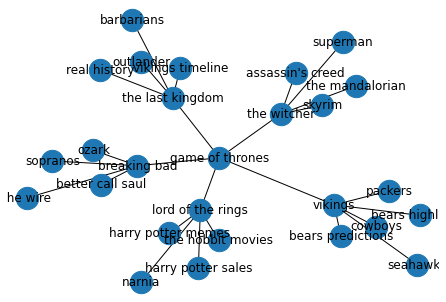

In [ ]:
nx.draw(EG, with_labels= True, node_size = 500, cmap = 'gray',  vmin=0, vmax=255)

Граф получился, но не такой наглядный как в оригинальной статье (хотя мы учитывали формат входных данных). Воспользуемся предложенной автором Flourish. Вариант из Flourish получился куда нагляднее. 

Таким образом, мы построили эго-граф по игре престолов, используя поисковые запросы с vs.

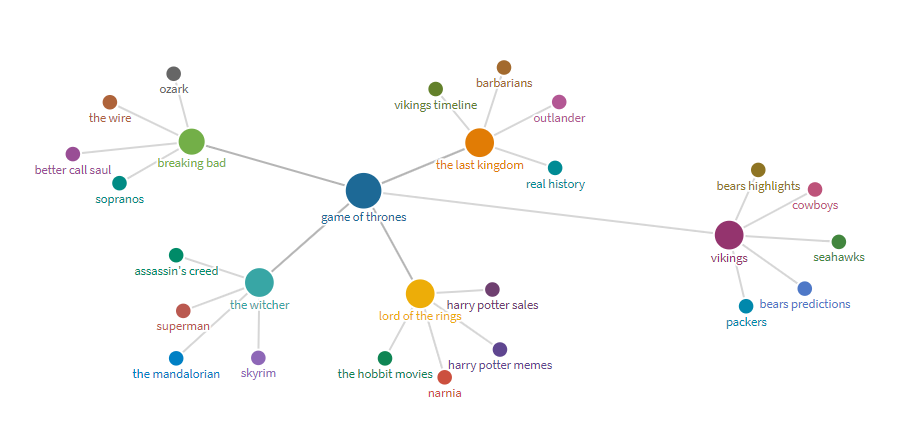